In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [3]:
cats = '/kaggle/input/dog-and-cat-classification-dataset/PetImages/Cat'
dogs = '/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog'

In [4]:

import cv2
import os
from tqdm import tqdm

features = []
labels = []
for img_name in tqdm(os.listdir(cats)):
    #print(os.path.join(cats, img_name))
    img = cv2.imread(os.path.join(cats, img_name))

    #Skip if img not loaded
    if img is None:
        print(f"Skipping file: {img_name}" )
        continue

    labels.append(0)
    img = cv2.resize(img, (128,128))
    features.append(img)


for img_name in tqdm(os.listdir(dogs)):
    #print(os.path.join(cats, img_name))
    img = cv2.imread(os.path.join(dogs, img_name))

    #Skip if img not loaded
    if img is None:
        print(f"Skipping file: {img_name}" )
        continue

    labels.append(1)
    img = cv2.resize(img, (128,128))
    features.append(img)

 83%|████████▎ | 10427/12499 [00:52<00:10, 198.93it/s]

Skipping file: 10404.jpg


100%|██████████| 12499/12499 [01:06<00:00, 188.79it/s]


In [5]:
import numpy as np
X = np.array(features)
y = np.array(labels)

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = True)
X_train = X_train.transpose(0, 3, 1, 2)   # (N, H, W, C) → (N, C, H, W)
X_test  = X_test.transpose(0, 3, 1, 2)

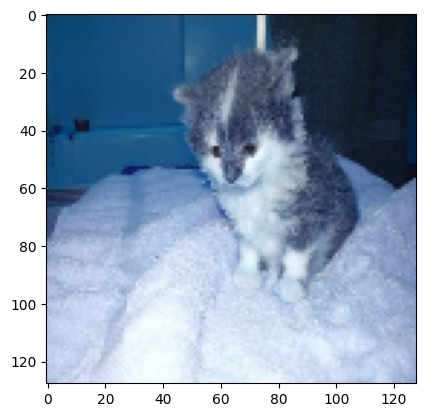

In [7]:
import matplotlib.pyplot as plt
plt.imshow(X[10])

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
class customdataset(Dataset):
    def __init__(self, features, label):
        self.features = torch.tensor(features, dtype=torch.float32)  # no .values
        self.label = torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.label[idx]


In [10]:
train_dataset = customdataset(X_train,y_train)
test_dataset = customdataset(X_test,y_test)
train_loader = DataLoader(train_dataset , batch_size = 32 , shuffle = True , pin_memory = True)
test_loader = DataLoader(test_dataset , batch_size = 32 , shuffle = False, pin_memory = True)
# pinmemory for faster execution

In [15]:
import torch
import torch.nn as nn

class CNN_DogsCats(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),  # 32768
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # 2 classes (dog vs cat)
        )

    def forward(self, X):
        x = self.features(X)
        x = self.classifier(x)
        return x


In [19]:
epochs= 100
learning_rate = 0.0001
model = CNN_DogsCats(X_train.shape[1])
model = model.to(device)
# model code above for gpu
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters() , lr = learning_rate)

In [17]:
X_train.shape

(19997, 3, 128, 128)

In [20]:
for epoch in range(epochs):
    totalepoch_loss = 0

    for batch_features, batch_labels in train_loader:
      # batch_features and labels to gpu
        batch_features, batch_labels = batch_features.to(device) , batch_labels.to(device)
        output = model(batch_features)
        loss = criterion(output, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalepoch_loss = totalepoch_loss + loss.item()

    avg_loss = totalepoch_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.6f}")

Epoch: 1, Loss: 0.664474
Epoch: 2, Loss: 0.622747
Epoch: 3, Loss: 0.602613
Epoch: 4, Loss: 0.586951
Epoch: 5, Loss: 0.571428
Epoch: 6, Loss: 0.553621
Epoch: 7, Loss: 0.545703
Epoch: 8, Loss: 0.533031
Epoch: 9, Loss: 0.520473
Epoch: 10, Loss: 0.512543
Epoch: 11, Loss: 0.499930
Epoch: 12, Loss: 0.493068
Epoch: 13, Loss: 0.482717
Epoch: 14, Loss: 0.472481
Epoch: 15, Loss: 0.465098
Epoch: 16, Loss: 0.458821
Epoch: 17, Loss: 0.449045
Epoch: 18, Loss: 0.442598
Epoch: 19, Loss: 0.432978
Epoch: 20, Loss: 0.424756
Epoch: 21, Loss: 0.418650
Epoch: 22, Loss: 0.409456
Epoch: 23, Loss: 0.402518
Epoch: 24, Loss: 0.394231
Epoch: 25, Loss: 0.388664
Epoch: 26, Loss: 0.379865
Epoch: 27, Loss: 0.370601
Epoch: 28, Loss: 0.364533
Epoch: 29, Loss: 0.355666
Epoch: 30, Loss: 0.351037
Epoch: 31, Loss: 0.342633
Epoch: 32, Loss: 0.334032
Epoch: 33, Loss: 0.326035
Epoch: 34, Loss: 0.320310
Epoch: 35, Loss: 0.306537
Epoch: 36, Loss: 0.301060
Epoch: 37, Loss: 0.296919
Epoch: 38, Loss: 0.289584
Epoch: 39, Loss: 0.27

In [38]:
import torch

correct = 0
total = 0

with torch.no_grad():  # no gradients needed for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)                # raw logits
        _, predicted = torch.max(outputs, 1)   # get class index (0 or 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 79.36%


In [37]:
all_preds = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
print(all_preds)

[np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)